# **Phase 1: Quantum Physics**
## 1 - Define the spin represenation of the model 
Hamiltonian of the fully connected transverse Ising model

$$H = \sum_{i=1}^{N} a_i X_i + \sum_{i=1}^{N} \sum_{j=1}^{i-1} J_{ij} Z_i Z_j
$$

where the coefficients $a_i$ and $J_{ij}$ are sampled randomly from a uniform distribution on
[0,1).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qat.lang.AQASM import Program, RY, CNOT, H, X
from qat.fermion import SpinHamiltonian
from qat.core import Observable, Term

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qat.lang.AQASM import Program, RY, CNOT, H, X
from qat.fermion import SpinHamiltonian
from qat.core import Observable, Term

def ising(N):
    np.random.seed(123)  
    N 
    terms = []

    # Generate random coefficients for the transverse field term (X)
    a_coefficients = np.random.random(N)
    for i in range(N):
        term = Term(coefficient=a_coefficients[i], pauli_op="X", qbits=[i])
        terms.append(term)

    # Generate random coefficients for the interaction term (ZZ)
    J_coefficients = np.random.random((N, N))
    for i in range(N):
        for j in range(i):
            if i != j:  # avoid duplicate terms
                term = Term(coefficient=J_coefficients[i, j], pauli_op="ZZ", qbits=[i, j])
                terms.append(term)
    ising = SpinHamiltonian(N, terms=terms)
    return ising

Contruct the ising model with $N = 3$

In [3]:
model = ising(3) 
print("Transverse Ising Model:", model)


Transverse Ising Model: 0.6964691855978616 * (X|[0]) +
0.28613933495037946 * (X|[1]) +
0.2268514535642031 * (X|[2]) +
0.9807641983846155 * (ZZ|[1, 0]) +
0.3921175181941505 * (ZZ|[2, 0]) +
0.3431780161508694 * (ZZ|[2, 1])


## 2-Contruct the Ansatz
Contruct the variational circuit (ansatz): linear staircase shape with slices of rotation and entanglement (simplest model)


In [4]:

# we construct the variational circuit (ansatz): hardware-efficient
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ
n_layers = 3
nqbits = 3


def HEA(nqbits, n_layers, rotation_gates, entangling_gate):

    prog = Program()
    reg = prog.qalloc(nqbits)
    theta = [prog.new_var(float, '\\theta_%s'%i) for i in range(n_layers*nqbits)]
    for ind_layer in range(n_layers):
        for qb in range(nqbits):
            rotation_gates(theta[ind_layer*nqbits + qb])(reg[qb])
            entangling_gate(reg[qb], reg[(qb+1)%nqbits])
    circ = prog.to_circ()
    return circ



def count(gate, mylist):
    """
    count function counts the number of gates in the given list
    params: it takes two parameters. first is which gate you want
    to apply like rx, ry etc. second it take the list of myqlm gates
    instruction.
    returns: it returns number of gates.
    """
    if type(gate) == type(str):
        gate = str(gate)
    if gate == gate.lower():
        gate = gate.upper()
    mylist = [str(i) for i in mylist]
    count = 0
    for i in mylist:
        if i.find("gate='{}'".format(gate)) == -1:
            pass
        else:
            count += 1
    return count


circ = HEA(nqbits, n_layers, RY, CNOT)
circ.display()


gates = circ.ops
cnot = count("CNOT", gates)
print("The number of CNOT gates for this circuit is:", cnot)


The number of CNOT gates for this circuit is: 9


### Hardware Efficient Ansatz Mathematics Expression

The variational ansatz consists of three key components applied sequentially to prepare quantum states for computation:

1. **State Preparation and Pre-rotations**:
   - The quantum system is initialized in a separable state:
     $$
     |\psi\rangle^{\otimes N} = \bigotimes_{j=0}^{N-1} |\psi_j\rangle
     $$
   - Pre-rotations are applied to each qubit, combining $R_z$ and $R_y$ gates:
     $$
     U_{\text{pre}} |\psi\rangle^{\otimes N} = \bigotimes_{j=0}^{N-1} \left[ R_y(\theta_{2,j}) R_z(\theta_{1,j}) |\psi_j\rangle \right]
     $$

2. **Entanglement Layer**:
   - The qubits are fully entangled using non-parameterized CX (CNOT) gates:
     $$
     U_{\text{ent}} = \prod_{j_1=0}^{N-2} \prod_{j_2=j_1+1}^{N-1} \text{CX}_{j_1,j_2}
     $$

3. **Post-rotations**:
   - Additional $R_z$ and $R_y$ rotations are applied to all qubits:
     $$
     U_{\text{rot}}(\theta) = \bigotimes_{j=0}^{N-1} \left[ R_y(\theta_{4,j}) R_z(\theta_{3,j}) \right]
     $$

4. **Complete Ansatz**:
   - The total ansatz combines all layers:
     $$
     U(\theta) = U_{\text{rot}}(\theta) U_{\text{ent}} U_{\text{pre}}(\theta)
     $$
   - Here, $\theta = \{\theta_{s,j}\}$ are the variational parameters controlling all $R_y$ and $R_z$ gates.

**Notes**:
- $s = 1, \dots, 4$ corresponds to the slices (or layers) of single-qubit gates.
- $j, j_1, j_2 \in \{0, 1, \dots, N-1\}$ are indices of the qubits.
- One "depth" is defined as the combined application of $U_{\text{rot}}$ and $U_{\text{ent}}$.

In [5]:
from HEA_built_model import Double_HEA

nqbits_exp = 4  # Number of qubits
n_layers_exp = 4  # Number of layers

# Generate the circuit
circ_exp = Double_HEA(nqbits_exp, n_layers_exp)
circ_exp.display()

## 3- Variational Quantum Eigensolver (VQE)


### Variational Quantum Eigensolver (VQE) Algorithm


This step-by-step explanation describes the VQE algorithm for finding the ground state energy of the **Transverse Ising Model** Hamiltonian.

---

#### 1. Define the Hamiltonian

The transverse Ising model Hamiltonian is given by:

$$
H = -\sum_{i} J \sigma_i^z \sigma_{i+1}^z - \sum_{i} h \sigma_i^x
$$

- $J$: Interaction strength between neighboring spins.
- $h$: Transverse field strength.
- $\sigma^z$, $\sigma^x$: Pauli matrices.

---

#### 2. Prepare the Variational Ansatz (Parameterized Circuit)

- Construct a **parametric circuit** $U_{\vec{\theta}}$ with:
  - Limited depth $T$ (number of layers of gates).
  - Limited width (number of qubits).
- The circuit encodes the trial wavefunction:
  $$
  |\psi_{\vec{\theta}}\rangle = U_{\vec{\theta}} |\phi_0\rangle
  $$
  where $|\phi_0\rangle$ is the initial state (e.g., all qubits initialized to $|0\rangle$).

---

#### 3. Initialize Parameters

- Start with an initial guess $\vec{\theta}_0$ for the variational parameters.

---

#### 4. Quantum Processor (QPU) Evaluation

On the **Quantum Processing Unit (QPU)**:

1. Prepare the quantum state:
   $$
   |\psi_{\vec{\theta}}\rangle = U_{\vec{\theta}} |\phi_0\rangle
   $$
2. Measure the expectation value of the Hamiltonian:
   $$
   E_{\vec{\theta}} = \langle \psi_{\vec{\theta}} | H | \psi_{\vec{\theta}} \rangle
   $$

---

### 5. Classical Processor (Optimization)

- Use a **classical optimizer** (e.g., COBYLA, BFGS, or Nelder-Mead) to minimize the energy $E_{\vec{\theta}}$.
- Input: Current parameters $\vec{\theta}_n$.
- Output: Updated parameters $\vec{\theta}_{n+1}$.
- The classical optimizer adjusts $\vec{\theta}$ iteratively based on the energy gradient or cost function value.

---

#### 6. Iterative Optimization Loop

Repeat the following steps until convergence:

1. **Update Parameters**:  
   Update $\vec{\theta}_n$ using the classical optimizer.

2. **Prepare and Measure on QPU**:  
   Prepare $|\psi_{\vec{\theta}_n}\rangle$ on the QPU and evaluate $E_{\vec{\theta}_n}$.

3. **Convergence Check**:  
   Check if the energy or gradient satisfies the stopping condition:
   $$
   |E_{\vec{\theta}_{n+1}} - E_{\vec{\theta}_n}| < \epsilon
   $$

---

#### 7. Output the Ground State Energy

- The algorithm outputs the minimum energy:
  $$
  E_{\vec{\theta}^*}
  $$
  where $\vec{\theta}^*$ are the optimal parameters.

---

### Summary

1. The **QPU** handles quantum state preparation and measurement.
2. The **Classical Processor** performs optimization using classical algorithms.
3. The hybrid approach combines the strengths of quantum devices and classical optimization to efficiently approximate the ground state energy of the transverse Ising model.

### VQE Stack
&nbsp;
<div align="center">
    <img src="Images/vqe_simple.png" width="80%">
</div>
<h4 align="center"><em>Adapted from HQI training program</em></h4>
&nbsp;

In [6]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin
import matplotlib.pyplot as plt
import numpy as np

# Define the job
job = circ.to_job(job_type="OBS",
                  observable=model,
                  nbshots=0)

# Define the QPU and optimization methods
linalg_qpu = get_default_qpu()
methods = ["COBYLA", "Nelder-Mead", "BFGS"]


# Store results
result = {}
for method in methods:
    optimizer_scipy = ScipyMinimizePlugin(method=method,
                                          tol=1e-6,
                                          options={"maxiter": 200},
                                          x0=np.random.rand(2*n_layers * nqbits))
    qpu = optimizer_scipy | linalg_qpu
    result[method] = qpu.submit(job)
    

    print("Minimum VQE energy (%s) = %s" % (method, result[method].value))


/Users/theking/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Minimum VQE energy (COBYLA) = -1.6446855723874412
Minimum VQE energy (Nelder-Mead) = -1.6113813718822103
Minimum VQE energy (BFGS) = -1.6446935536814191


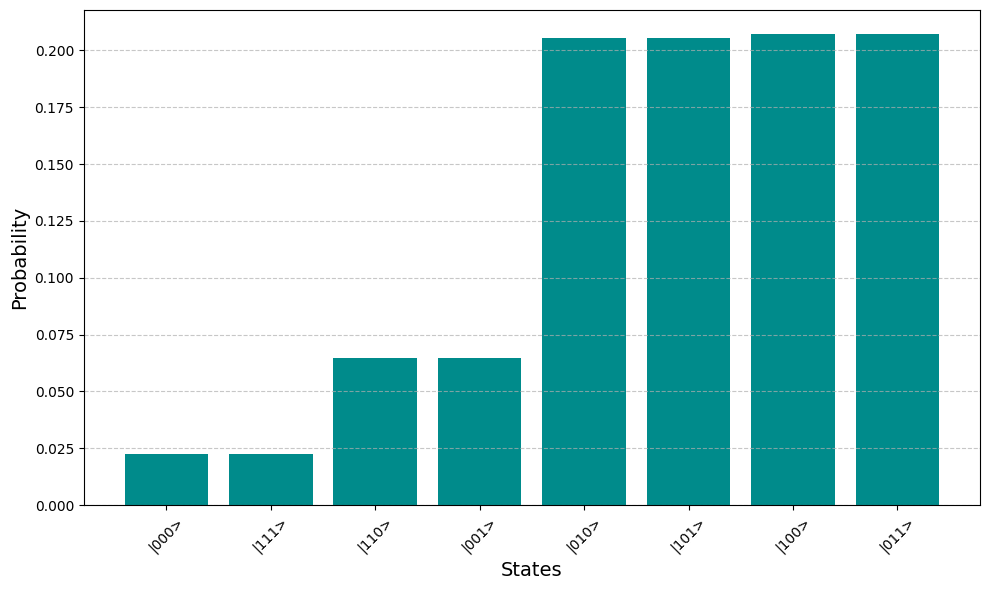


Sorted Results:
|000>: 0.022537567796011713
|111>: 0.022537702060828127
|110>: 0.06452046269674677
|001>: 0.06452048498993489
|010>: 0.20552758835571014
|101>: 0.20552912129265521
|100>: 0.2074134154854703
|011>: 0.20741365732264283


In [7]:
import os
import matplotlib.pyplot as plt

# Bind variables to the circuit and create a job
opt_circ = circ.bind_variables(eval(result[method].meta_data["parameter_map"]))
job = opt_circ.to_job()

# Evaluate the job and retrieve results
result_opt = get_default_qpu().submit(job)

# Create folders for saving results
os.makedirs("Figures", exist_ok=True)
os.makedirs("Save_Data", exist_ok=True)

# Save the results to a text file in Save_Data folder
with open("Save_Data/results.txt", "w") as file:
    file.write("State\tProbability\n")
    for sample in result_opt:
        file.write(f"{str(sample.state)}\t{sample.probability}\n")

# Extract states and probabilities
states = [str(sample.state) for sample in result_opt]  # Convert State objects to strings
probabilities = [sample.probability for sample in result_opt]

# Sort probabilities and states in ascending order of probabilities
sorted_indices = sorted(range(len(probabilities)), key=lambda i: probabilities[i])
sorted_states = [states[i] for i in sorted_indices]
sorted_probabilities = [probabilities[i] for i in sorted_indices]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.bar(sorted_states, sorted_probabilities, color="darkcyan")
plt.xlabel("States", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Save the plot in the Figures folder
plt.savefig("Figures/probability_histogram.pdf")
plt.show()

# Print sorted results to the console
print("\nSorted Results:")
for state, probability in zip(sorted_states, sorted_probabilities):
    print(f"{state}: {probability}")

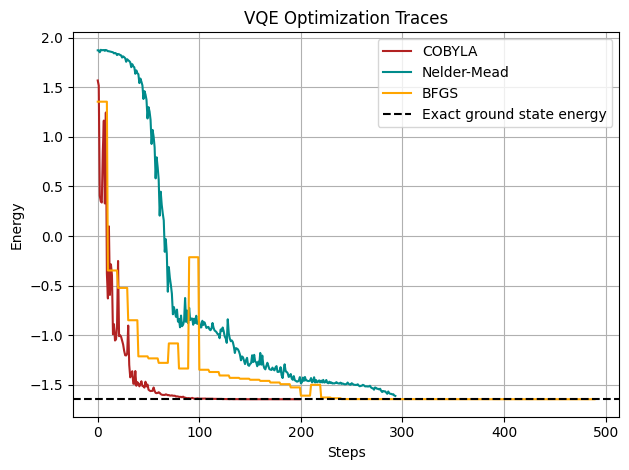

Results saved to 'Save_Data/vqe_output.txt' and plot saved as 'Figures/fig_vqe_ising.pdf'.


In [8]:
import os
import matplotlib.pyplot as plt

# Sample result data structure for testing
methods = ["COBYLA", "Nelder-Mead", "BFGS"]
colors = {"COBYLA": "firebrick", "Nelder-Mead": "darkcyan", "BFGS": "orange"}

# Create folders for saving results
os.makedirs("Figures", exist_ok=True)
os.makedirs("Save_Data", exist_ok=True)

# Open a file to save the output in the Save_Data folder
with open("Save_Data/vqe_output.txt", "w") as file:
    file.write("VQE Optimization Results\n")
    file.write("=" * 80 + "\n")

    for method in methods:
        file.write(f"Method: {method}\n")
        file.write("-" * 80 + "\n")
        
        vals_U = result[method].meta_data["optimization_trace"]
        trace_U = eval(vals_U)
        xlist_U = result[method].value
        ylist_U = result[method].meta_data["parameters"]
        
        # Save the values to the file
        file.write(f"Evaluated energy for each step: {trace_U}\n")
        file.write(f"Minimum VQE energy: {xlist_U}\n")
        file.write(f"Theta optimization updated: {ylist_U}\n\n")
        
        # Plot the optimization trace
        plt.plot(trace_U, label=method, color=colors[method])
    
    file.write("=" * 80 + "\n")
    file.write("End of Results\n")

# Plot optimization traces
plt.axhline(xlist_U, color='black', linestyle='--', label="Exact ground state energy")
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.grid(True)
plt.title("VQE Optimization Traces")
plt.tight_layout()

# Save the plot in the Figures folder
plt.savefig("Figures/fig_vqe_ising.pdf")
plt.show()

print("Results saved to 'Save_Data/vqe_output.txt' and plot saved as 'Figures/fig_vqe_ising.pdf'.")

### Gradient-Based Optimizers

Gradient-based optimizers aim to minimize a cost function by iteratively updating parameters based on gradient information. Below are the steps involved:

---

### 1. Compute the New Parameters

The optimizer computes new parameter values at the $k$-th step using the following update rule:
$$
\theta_{k+1} = \theta_k - \eta \nabla f(\theta_k)
$$

- $\theta_k$: Parameter at the $k$-th step.
- $\eta$: User-defined hyperparameter (step size).
- $\nabla f(\theta_k)$: Gradient vector of the function $f(\theta)$ at step $k$.

---

### 2. Gradients in the BFGS Method

The gradient vector $\nabla f(\theta_k)$ is calculated as:
$$
\nabla_k f(\theta) = \nabla_{k+1} f(\theta_{k+1}) + B_{k+1} (\theta_k - \theta_{k+1}),
$$
where:
- $B_{k+1}$: Approximation to the inverse Hessian matrix.
- $\theta_k - \theta_{k+1}$: Change in the parameters between steps.

---

### 3. Update the Inverse Hessian Approximation $B_{k+1}$

The inverse Hessian $B_{k+1}$ is updated iteratively using the following rule:
$$
B_{k+1} = B_k + \frac{y_k (y_k)^T}{(y_k)^T \Delta \theta_k} - \frac{B_k \Delta \theta_k (\Delta \theta_k)^T B_k}{(\Delta \theta_k)^T B_k \Delta \theta_k},
$$

where:
- $y_k = \nabla f(\theta_{k+1}) - \nabla f(\theta_k)$: Difference in gradients.
- $\Delta \theta_k = \theta_{k+1} - \theta_k$: Parameter update step.

---

### 4. Extend to Limited-Memory BFGS (L-BFGS)

- **L-BFGS** is a memory-efficient variant of the BFGS algorithm.
- Instead of storing the full Hessian matrix $n \times n$, L-BFGS stores a small number of vectors to approximate the matrix $B_k^{-1}$.
- This reduces memory usage for large systems, making the method scalable.

---
### 5. Parameter-Shift Rule for Quantum Systems

- In quantum systems, the gradient $\nabla f(\theta_k)$ can often be expressed as a linear combination of quantum functions.
$$
\nabla_{\theta_i} f(x; \theta) = \frac{1}{2} \left[ f\left(x; \theta + \frac{\pi}{2}\right) - f\left(x; \theta - \frac{\pi}{2}\right) \right]
$$
- These functions typically use the **same quantum circuit** but with a shifted argument.
- This approach, known as the **parameter-shift rule**, avoids explicitly calculating derivatives, relying instead on quantum measurements.



min eigval =  -1.6446935536839147


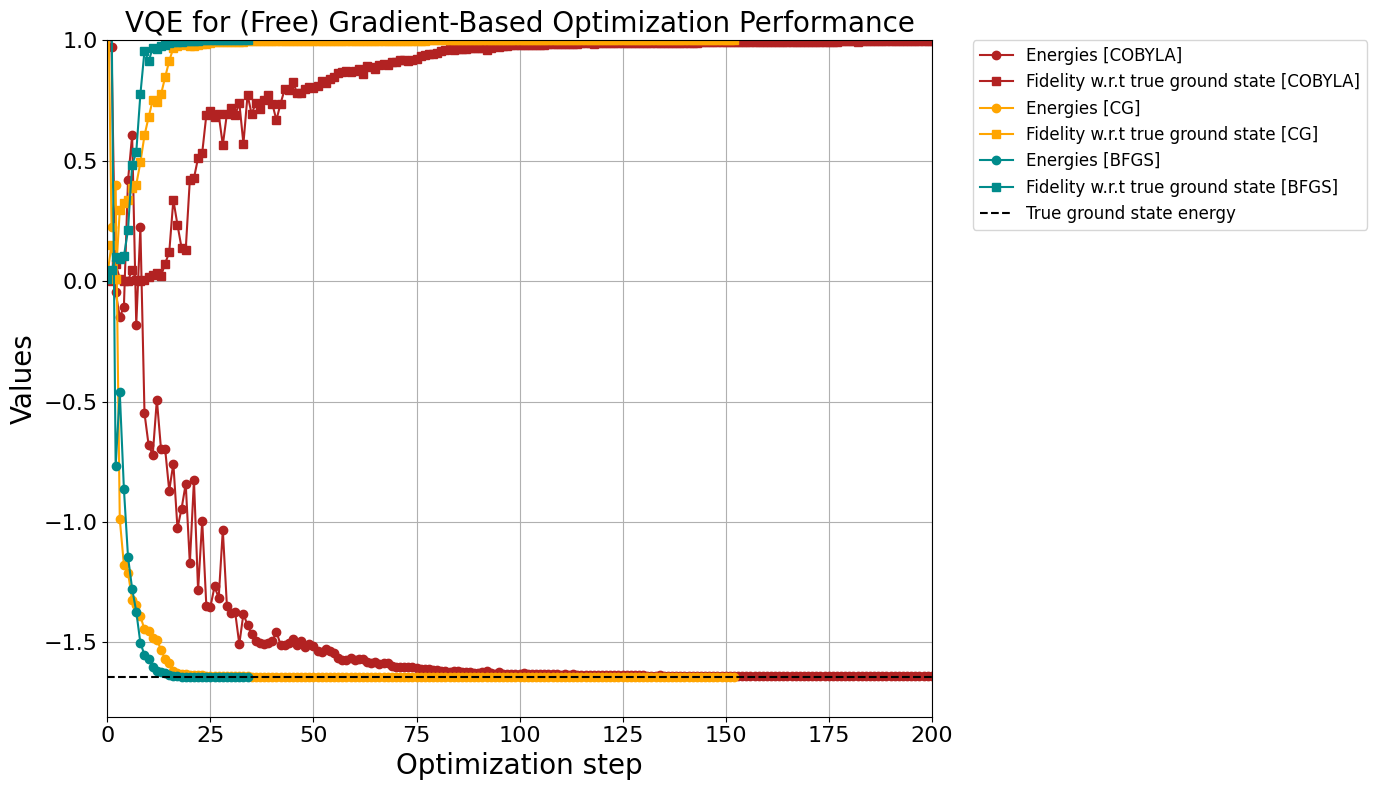

Results saved to 'Save_Data/optimization_results.txt' and plot saved as 'Figures/fig_pmrs_ising.pdf'.


In [9]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
from optimization_utils import get_optimization_func, get_grad_func, compute_eigen_values

# Create folders for saving results
os.makedirs("Figures", exist_ok=True)
os.makedirs("Save_Data", exist_ok=True)

# Dictionary to store results
res = {}
energy_list, fid_list = {}, {}

# Compute eigenvalues and eigenvectors
E0, psi0 = compute_eigen_values(model)

# List of optimization methods to use
methods = ["COBYLA", "CG", "BFGS"]

# Colors for methods
col = {"CG": "orange", "COBYLA": "firebrick", "BFGS": "darkcyan"}

# Open a file to save the results
with open("Save_Data/optimization_results.txt", "w") as file:
    file.write("Optimization Results\n")
    file.write("=" * 80 + "\n")
    
    # Loop through each method
    for method in methods:
        energy_list[method], fid_list[method] = [], []
        
        # Get optimization function and gradient
        my_func = get_optimization_func(circ, qpu, model, method, nqbits, psi0, energy_list, fid_list)
        my_grad = None  # Initialize as None for methods that don't need gradients (like COBYLA)
        
        # Only set the gradient for methods (Conjugated Gradient (CG) and BFGS) that require it
        if method in ["CG", "BFGS"]:
            my_grad = get_grad_func(circ, qpu, model)
        
        # Run optimization
        res[method] = scipy.optimize.minimize(
            my_func,
            jac=my_grad,  # Gradient is provided only for CG and BFGS
            x0=np.random.rand(n_layers * nqbits),  # Initial guess
            method=method
        )
        
        # Save optimization steps to the file
        file.write(f"Method: {method}\n")
        file.write(f"Number of optimization steps: {len(energy_list[method])}\n")
        file.write(f"Energies: {energy_list[method]}\n")
        file.write(f"Fidelities: {fid_list[method]}\n")
        file.write("-" * 80 + "\n")
    
    file.write("=" * 80 + "\n")
    file.write("End of Results\n")

# Plot results with custom styles
plt.figure(figsize=(14, 8))  # Larger plot size
for method in methods:
    plt.plot(
        energy_list[method],
        "-o",  # Line style with circle markers
        color=col[method],  # Use custom color
        label=f"Energies [{method}]"
    )
    plt.plot(
        fid_list[method],
        "-s",  # Line style with square markers
        color=col[method],  
        label=f"Fidelity w.r.t true ground state [{method}]"
    )
plt.plot([E0] * len(energy_list[methods[0]]), "k--", label="True ground state energy")
plt.xlabel("Optimization step", fontsize=20)
plt.ylabel("Values", fontsize=20)
plt.xlim(0, 200)
plt.ylim(None, 1)

plt.xticks(fontsize=16)  # Set font size for x-axis tick labels
plt.yticks(fontsize=16) 

# Move the legend box outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=12)
plt.grid()
plt.title("VQE for (Free) Gradient-Based Optimization Performance", fontsize=20)
plt.tight_layout()  # Adjust layout to prevent clipping

# Save the plot in the Figures folder
plt.savefig("Figures/fig_pmrs_ising.pdf")
plt.show()

print("Results saved to 'Save_Data/optimization_results.txt' and plot saved as 'Figures/fig_pmrs_ising.pdf'.")

# Phase 2: Quantum Chemistry

## The QLM Workflow for Quantum Chemistry

&nbsp;
<div align="center">
    <img src="Images/QLM_flowchart.png" width="80%">
    <p><em>The QLM workflow for quantum chemistry. <strong>Top row:</strong> Steps to prepare a variational quantum job containing a parameterized circuit and the Hamiltonian whose ground state energy one wants to approximate. The leftmost (gray) box uses standard third-party quantum chemistry modules. Orange boxes stand for QLM libraries. <strong>Bottom row:</strong> QLM stack, with plugins (orange boxes) that pre- and post-process the job and results, and a QPU (green box) that executes the quantum job and returns a result.</em></p>
</div>
&nbsp;

In [10]:
from molecule_ucc_computation import get_parameters, compute_circuit_and_hamiltonian

In [11]:
H_sp, circ, qpu, nqbits, theta_0 = compute_circuit_and_hamiltonian('H2')

Computation info: {'MP2': -1.129524574850788, 'FCI': -1.137117067345732, 'HF': -1.1161514489386026}
Number of qubits 4
Spin representaion of Hamiltonian (-0.10973055606700646+0j) * I^4 +
(0.16821198673715732+0j) * (ZZ|[0, 1]) +
(0.12005143072546032+0j) * (ZZ|[0, 2]) +
(0.16549431486978655+0j) * (ZZ|[1, 2]) +
(0.16549431486978655+0j) * (ZZ|[0, 3]) +
(0.16988452027940365+0j) * (Z|[0]) +
(0.12005143072546032+0j) * (ZZ|[1, 3]) +
(0.16988452027940365+0j) * (Z|[1]) +
(0.04544288414432622+0j) * (XYYX|[0, 1, 2, 3]) +
(-0.04544288414432622+0j) * (XXYY|[0, 1, 2, 3]) +
(-0.04544288414432622+0j) * (YYXX|[0, 1, 2, 3]) +
(0.04544288414432622+0j) * (YXXY|[0, 1, 2, 3]) +
(0.17395378776494133+0j) * (ZZ|[2, 3]) +
(-0.2188630678121966+0j) * (Z|[2]) +
(-0.2188630678121966+0j) * (Z|[3])


/Users/theking/Documents/sorbonne/molecule_ucc_computation.py:218: UserWarning: This guess_init_state function is deprecated.
  cluster_ops, theta_0, hf_init = get_cluster_ops_and_init_guess(nels, noons_full, orb_energies_full, H.hpqrs)


In [12]:
circ.display()

min eigval =  -1.1371170673457314
Optimization terminated successfully.
         Current function value: -1.137117
         Iterations: 2
         Function evaluations: 5
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: -1.137117
         Iterations: 3
         Function evaluations: 4
         Gradient evaluations: 4

   Normal return from subroutine COBYLA

   NFVALS =   45   F =-1.137117E+00    MAXCV = 0.000000E+00
   X = 2.600332E-05   2.606796E-05   1.147918E-01


/var/folders/lk/3s873myd73q2lv3wl49q7n6h0000gn/T/ipykernel_44540/905061388.py:20: RuntimeWarning: Method COBYLA does not use gradient information (jac).
  res[method] = scipy.optimize.minimize(


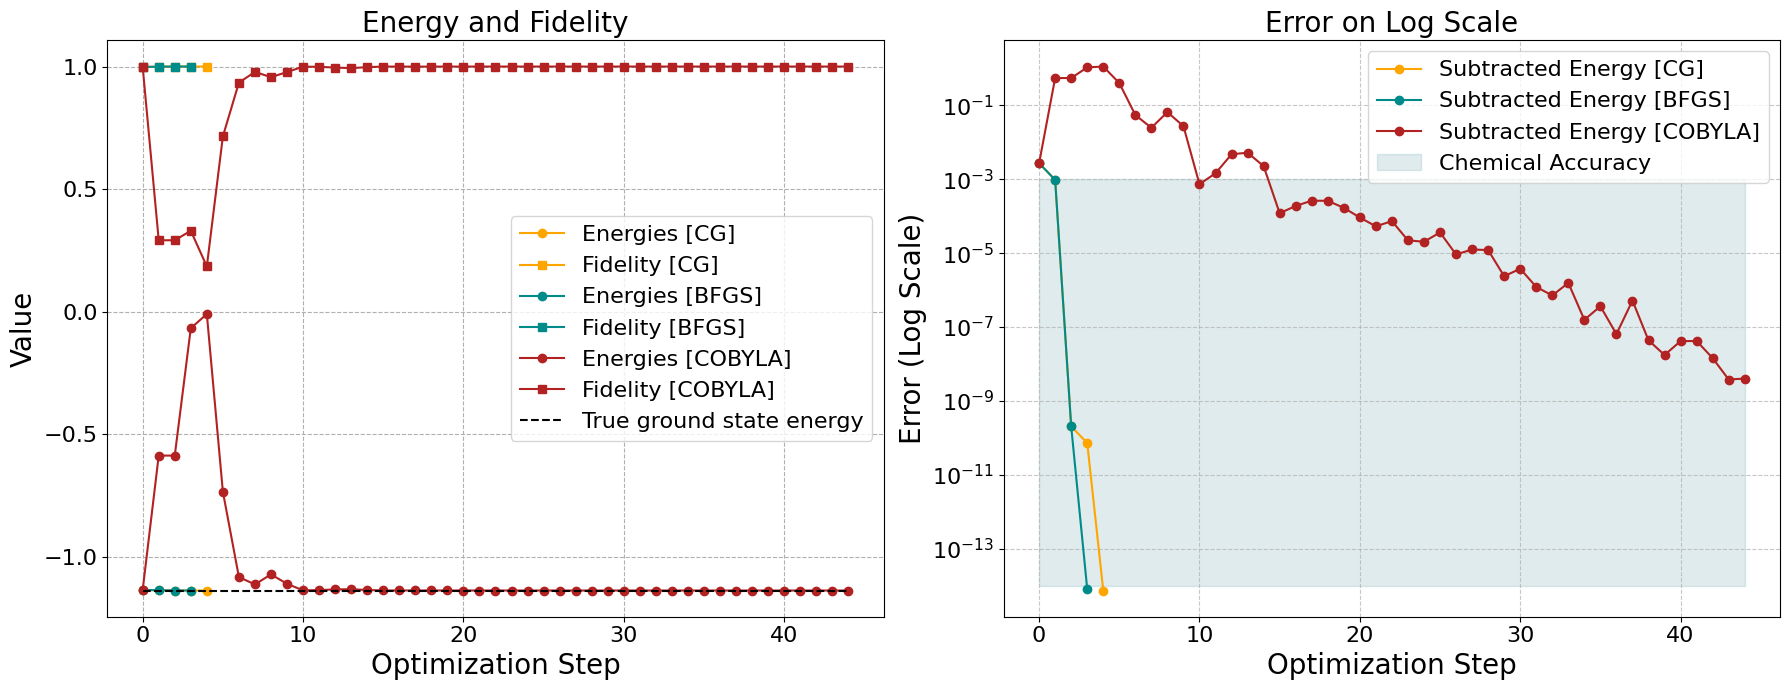

Results saved to 'Save_Data/optimization_results_H2.txt' and plot saved as 'Figures/fig_pmrs_H2.pdf'.


In [13]:
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt

# Create folders for saving results
os.makedirs("Figures", exist_ok=True)
os.makedirs("Save_Data", exist_ok=True)

# Compute eigenvalues and initialize results
E0, psi0 = compute_eigen_values(H_sp)
res = {}
energy_list, fid_list = {}, {}

# Optimization
for method in ["CG", "BFGS", "COBYLA"]:
    energy_list[method], fid_list[method] = [], []
    my_func = get_optimization_func(circ, qpu, H_sp, method, nqbits, psi0, energy_list, fid_list)
    my_grad = get_grad_func(circ, qpu, H_sp)
    res[method] = scipy.optimize.minimize(
        my_func, 
        jac=my_grad, 
        x0=theta_0, 
        method=method, 
        options={"maxiter": 50000, "disp": True}
    )


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
col = {"CG": "orange", "COBYLA": "firebrick", "BFGS": "darkcyan"}

# Plot 1: Energies and fidelity
for method in ["CG", "BFGS", "COBYLA"]:
    ax1.plot(energy_list[method], marker='o', color=col[method], label=f"Energies [{method}]")
    ax1.plot(fid_list[method], marker='s', color=col[method], label=f"Fidelity [{method}]")
ax1.plot(
    [E0] * max(len(energy_list[method]) for method in ["CG", "BFGS", "COBYLA"]), 
    "k--", 
    label="True ground state energy"
)
ax1.set_xlabel("Optimization Step", fontsize=20)
ax1.set_ylabel("Value", fontsize=20)
ax1.legend(fontsize=16)  
ax1.grid(True, which="both", ls="--")
ax1.set_title("Energy and Fidelity", fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)

# Plot 2: Subtracted energy on log scale
steps = np.arange(0, 100)
for method in ["CG", "BFGS", "COBYLA"]:
    energy_list[method] = np.array(energy_list[method])
    error = np.maximum(energy_list[method] - E0, 1e-16)  
    ax2.plot(error, "-o", color=col[method], label=f"Subtracted Energy [{method}]")
    if method == "COBYLA" and error.size > 0:
        ax2.fill_between(
            steps[:len(error)], 
            1e-14, 
            1e-3, 
            color="cadetblue", 
            alpha=0.2, 
            interpolate=True, 
            label="Chemical Accuracy"
        )
ax2.set_xlabel("Optimization Step", fontsize=20)
ax2.set_ylabel("Error (Log Scale)", fontsize=20)
ax2.set_yscale('log')
ax2.legend(fontsize=16, loc='upper right')  
ax2.grid(True, which="both", ls="--", alpha=0.7)
ax2.set_title("Error on Log Scale", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)

plt.tight_layout()

# Save the plot in the Figures folder
plt.savefig("Figures/fig_pmrs_H2.pdf")
plt.show()

# Save results to a text file
with open("Save_Data/optimization_results_H2.txt", "w") as file:
    file.write("Optimization Results\n")
    file.write("=" * 80 + "\n")
    for method in ["CG", "BFGS", "COBYLA"]:
        file.write(f"Method: {method}\n")
        file.write(f"Number of optimization steps: {len(energy_list[method])}\n")
        file.write(f"Energies: {energy_list[method]}\n")
        file.write(f"Fidelities: {fid_list[method]}\n")
        file.write("-" * 80 + "\n")
    file.write("=" * 80 + "\n")
    file.write("End of Results\n")

print("Results saved to 'Save_Data/optimization_results_H2.txt' and plot saved as 'Figures/fig_pmrs_H2.pdf'.")